In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 44.9 MB/s 


In [ ]:
!pip install matplotlib_scalebar

In [ ]:
!pip install spaghetti

     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 994 kB 9.1 MB/s 
     |████████████████████████████████| 95 kB 4.4 MB/s 
     |████████████████████████████████| 2.4 MB 35.4 MB/s 
  Created wheel for esda: filename=esda-2.4.1-py3-none-any.whl size=117429 sha256=e7715c281ce615405cc6ca099747136861de090e2d41b65f387df6ed2440113a
  Stored in directory: /root/.cache/pip/wheels/ed/67/c5/4558a178be4c410f341c31f71b5aba9c761a40c9d17dbdfddd
Successfully built esda


In [ ]:
!pip install mip

     |████████████████████████████████| 48.0 MB 42 kB/s 


In [24]:
!pip install gurobipy

In [ ]:
!pip install ortools

     |████████████████████████████████| 14.5 MB 93 kB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 
     |████████████████████████████████| 131 kB 59.8 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.12.0
    Uninstalling absl-py-0.12.0:
      Successfully uninstalled absl-py-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.2.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import geopandas
import io

In [ ]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

import numpy as np
import folium

/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


# 여기서부터 수정

In [333]:
#파일 직접 업로드하기
from google.colab import files
myfile = files.upload()


Saving 중량구 신호등.csv to 중량구 신호등.csv


In [334]:
right = pd.read_csv('중량구 신호등.csv', encoding='utf-8')
right = right.iloc[::2]
#right = right.iloc[::2]
print(right)
print(right.shape[0])

         id         xcoord         ycoord
0       248  208044.930851  555967.929541
2       250  208984.525322  555004.233742
4       268  206766.452866  555039.343177
6       357  208453.469884  557218.606598
8       369  208502.662060  557182.800750
...     ...            ...            ...
1522  37132  206674.682191  557047.904555
1524  37220  207237.262371  553768.668668
1526  37222  207089.999689  553773.499795
1528  37245  208901.184583  557241.425033
1530  37297  207091.819549  553761.810505

[766 rows x 3 columns]
766


In [335]:
#가져온 데이터가 기존에 5179좌표계여서 set_crs만 진행
right = geopandas.GeoDataFrame(right, geometry=geopandas.points_from_xy(right['xcoord'], right['ycoord']))
right.set_crs(epsg = 5179, inplace = True)
right.head(2)

,id,xcoord,ycoord,geometry
0,248,208044.930851,555967.929541,POINT (208044.931 555967.930)
2,250,208984.525322,555004.233742,POINT (208984.525 555004.234)


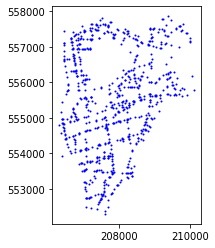

In [336]:
right.plot(color='blue', markersize = 1)

In [337]:
df = right

# mclp

In [338]:
# 모든 grid의 중심 좌표를 후보지로 선정 - gruobipy 라이센스 필요
def generate_candidate_sites(df):
    sites = []
    for _, row in df.iterrows():
        sites.append([row['geometry'].centroid.coords[0][0], row['geometry'].centroid.coords[0][1]])
    return np.array(sites)
    #M 안구함

In [339]:
from mip import Model, xsum, maximize, BINARY
from scipy.spatial import distance_matrix
import time
from gurobipy import *

def mclp(df, K, M, radius):
    start = time.time()
    sites = generate_candidate_sites(df)
    I = J = sites.shape[0]
    D = distance_matrix(sites, sites)
    mask1 = D <= radius
    D[mask1] = 1
    D[~mask1] = 0

    # MCLP 모델 생성
    m = Model()

    # 변수 추가
    x = {}
    y = {}
    
    # i, j는 binary(0과 1로만 이루어진) 변수
    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name=f"y{i}")
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name=f"x{j}")

    m.update()
    
    # 제약식 추가
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
#     print('----- Output -----')
#     print('  Running time : %s seconds' % float(end-start))
#     print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites, m.objVal

In [340]:
radius = 1000
K = 10
M = right.shape[0]
opt_sites_org, f = mclp(df, K, M, radius)
print('Cover되는 수요 지점의 개수 : {}'.format(f))


Cover되는 수요 지점의 개수 : 766.0


In [341]:
opt_df= pd.DataFrame(opt_sites_org, columns=['lon', 'lat'])
opt_df['geom'] = opt_df.apply(lambda r: Point(r['lon'], r['lat']), axis=1)
gdf = geopandas.GeoDataFrame(opt_df, geometry='geom', crs='epsg:5179')
#gdf = gdf.to_crs(epsg=4329)
gdf['lon'] = gdf['geom'].apply(lambda p:p.x)
gdf['lat'] = gdf['geom'].apply(lambda p:p.y)

In [342]:
print(gdf)

             lon            lat                           geom
0  206379.619250  553927.461520  POINT (206379.619 553927.462)
1  206493.773398  554423.361317  POINT (206493.773 554423.361)
2  207187.447496  557212.243186  POINT (207187.447 557212.243)
3  207052.515451  555964.089174  POINT (207052.515 555964.089)
4  208308.029095  556843.685281  POINT (208308.029 556843.685)
5  208345.769238  553595.424823  POINT (208345.769 553595.425)
6  208141.443751  554945.904515  POINT (208141.444 554945.905)
7  209919.238920  557403.291388  POINT (209919.239 557403.291)
8  207415.957031  552556.789775  POINT (207415.957 552556.790)
9  209483.176448  556016.685352  POINT (209483.176 556016.685)


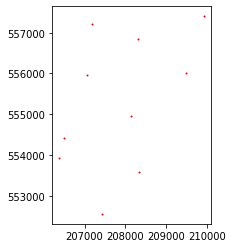

In [343]:
gdf.plot(color='red', markersize = 1)

In [344]:
gdf.to_csv('/content/중량구신호등mclp.csv')